# Manual Shadow calculation from LIDAR

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

import zipfile
from osgeo import gdal
import requests
import io
from IPython.display import Image
from ipyleaflet import Map, ImageOverlay

from tqdm import tqdm
import pvlib
import pandas as pd

## Select a tile

In [11]:
# Berlin DEM data
# see here: https://fbinter.stadt-berlin.de/fb/berlin/service_intern.jsp?id=a_dom1@senstadt&type=FEED


## Load Data

### DOM: Digitales Oberflächen Modell

In [17]:
tile = "386_5818"
link_to_tile = f"https://fbinter.stadt-berlin.de/fb/atom/DOM/DOM1_{tile}.zip"

response = requests.get(link_to_tile)
assert response.status_code == 200

dom1_33_386_5818_2_be.txt


### Airborne Laserscanning (ALS) Segmented Data
Direkter Download des Datensatzes
Airborne Laserscanning (ALS) Primäre 3D Laserscan-Daten - Download-Service - EPSG:25833 - las, gezippt.
Erläuterung	Übersicht Downloadpakete, Flächenabdeckung je Datei 1 x 1 km
- Mitte (37,3 GB)	https://fbinter.stadt-berlin.de/lidar//Mitte.zip
- Nord (32,5 GB)	https://fbinter.stadt-berlin.de/lidar/Nord.zip
- Nordost (1 GB)	https://fbinter.stadt-berlin.de/lidar/Nordost.zip
- Nordwest (16,3 GB)	https://fbinter.stadt-berlin.de/lidar/Nordwest.zip
- Ost (16,1 GB)	https://fbinter.stadt-berlin.de/lidar/Ost.zip
- Süd (35,3 GB)	https://fbinter.stadt-berlin.de/lidar/Sued.zip
- Südost (50 GB)	https://fbinter.stadt-berlin.de/lidar/Suedost.zip
- Südwest (32 GB)	https://fbinter.stadt-berlin.de/lidar/Suedwest.zip
- West (27,3 GB)	https://fbinter.stadt-berlin.de/lidar/West.zip

In [69]:
#Image(url='https://fbinter.stadt-berlin.de/fb/atom/DOP/Blattschnitt2x2km.gif')

In [105]:
nordost.split("/")[-1][:-4]

'Nordost'

In [92]:
nordost = "https://fbinter.stadt-berlin.de/lidar/Nordost.zip"
response_als = requests.get(nordost)
assert response_als.status_code == 200

In [110]:
def process_with_translate(input_file, dst_srs='EPSG:4326'):
    # 1. Convert to GeoTIFF
    intermediate_tif = "intermediate.tif"  # output from gdal_translate
    gdal.Translate(intermediate_tif, input_file, format='GTiff')

    # Run GDALwarp to convert from EPSG:25833 projection to ESPG:4326
    output_tif = "output.tif"  # output from gdalwarp
    gdal.Warp(output_tif, intermediate_tif, srcSRS='EPSG:25833', dstSRS=dst_srs)

    # 3. Apply DEM processing
    hillshade_tif = "hillshade.tif"  # output from DEMProcessing
    ds = gdal.DEMProcessing(hillshade_tif, output_tif, 'hillshade')
    gdal.DEMProcessing("")
    return ds

def process(r):
    #data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    for filename in z.namelist():
        file_path = os.path.join('data', f'temp_{filename}.xyz')
        print(filename)
        """
        # Open each file
        with z.open(filename) as f:
            # Check if the file is a raster file by checking the extension
            with open(data_path, 'wb') as temp_file:
                temp_file.write(f.read())
            # Process the XYZ file with Translate
                #process_with_translate(file_path, 'EPSG:3857')  # replace 'output.tif' with your preferred output filename
"""
process(response_als)

3dm_33_400_5826_1_be.las
3dm_33_400_5827_1_be.las
3dm_33_400_5828_1_be.las
3dm_33_400_5832_1_be.las
3dm_33_400_5833_1_be.las
3dm_33_400_5834_1_be.las
3dm_33_401_5826_1_be.las
3dm_33_401_5827_1_be.las
3dm_33_402_5826_1_be.las
3dm_33_402_5827_1_be.las
3dm_33_403_5826_1_be.las


In [106]:
class ALSdata():
    def __init__(self):
        self.set_paths()
        self.src_srs = "EPSG:25833"
        
    def set_paths(self):
        """Create a folder 
        in the same directory unless otherwise specified
        """
        self.data_path = os.path.join(os.getcwd(), "data")
        #file_path = os.path.join(data_path, f'temp_{filename}.xyz')

    def request_data_from_url(self, url):
        response = requests.get(url)
        assert response.status_code == 200
        self.response = response


    def download_file(self, url):
        self.local_filename = os.path.join(self.data_path, url.split("/")[-1])

        response = requests.get(url, stream=True)

        file_size = int(response.headers.get('Content-Length', 0))
        progress = tqdm(response.iter_content(1024), f'Downloading {self.local_filename}', total=file_size, unit='B', unit_scale=True, unit_divisor=1024)

        with open(self.local_filename, 'wb') as f:
            for data in progress.iterable:
                f.write(data)
                progress.update(len(data))

    def write_als_locally(self):
        with zipfile.ZipFile(self.local_filename, 'r') as zip_ref:
            for member in tqdm(zip_ref.infolist(), desc='Extracting '):
                zip_ref.extract(member, self.data_path)
        print(f"Extracted all files to directory: {os.path.abspath(self.data_path)}")

    def write_single_file_locally(self):
        with zipfile.ZipFile(response, 'r') as zip_ref:
            zip_ref.extractall(self.data_path)
        print(f"Extracted all files to directory: {os.path.abspath(self.data_path)}")

    def write_zip_locally(self):
        z = zipfile.ZipFile(io.BytesIO(self.response.content))
        for filename in z.namelist():
            # Open each file
            with z.open(filename) as f:
                file_path = os.path.join(self.data_path, filename)
                # Check if the file is a raster file by checking the extension
                with open(file_path, 'wb') as temp_file:
                    temp_file.write(f.read())
    
    def process_with_translate(self, input_file, dst_srs='EPSG:4326'):
        # 1. Convert to GeoTIFF
        intermediate_tif = "intermediate.tif"  # output from gdal_translate
        gdal.Translate(intermediate_tif, input_file, format='GTiff')

        # Run GDALwarp to convert from EPSG:25833 projection to ESPG:4326
        output_tif = "output.tif"  # output from gdalwarp
        gdal.Warp(output_tif, intermediate_tif, srcSRS='EPSG:25833', dstSRS=dst_srs)

        # 3. Apply DEM processing
        hillshade_tif = "hillshade.tif"  # output from DEMProcessing
        ds = gdal.DEMProcessing(hillshade_tif, output_tif, 'hillshade')
        gdal.DEMProcessing("")
        return ds
        # Process the XYZ file with Translate
        #process_with_translate(file_path, 'EPSG:3857')  # replace 'output.tif' with your preferred output filename

        


In [114]:
nord_ost = ALSdata()
nord_ost.download_file(nordost)
nord_ost.write_als_locally()

AttributeError: 'Response' object has no attribute 'seek'

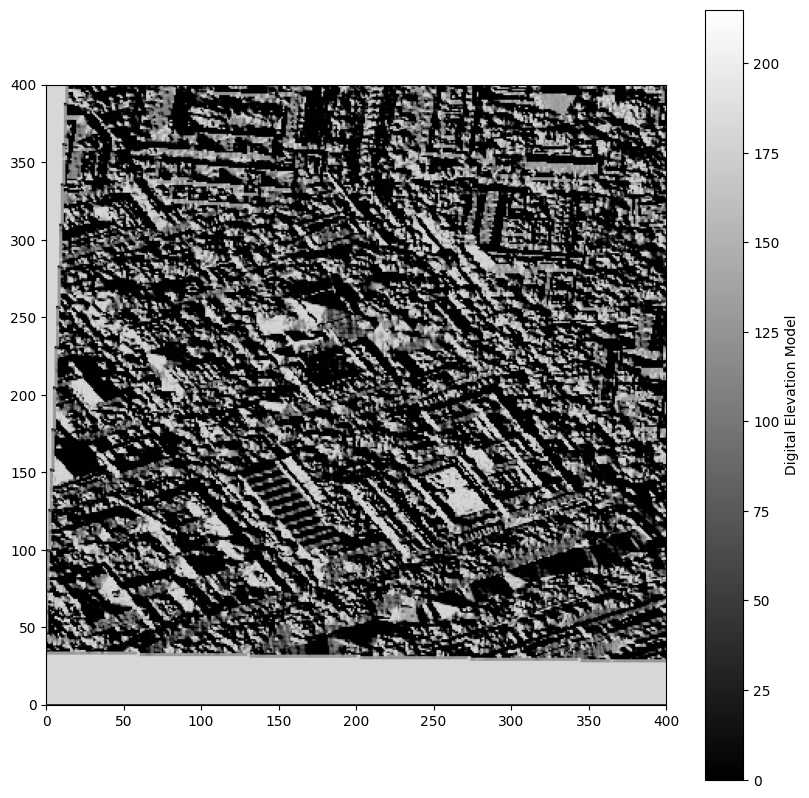

In [64]:
# Open the file
file_path = os.path.join('data', 'hillshade.tif')
with rio.open(file_path) as ds:
    img = ds.read(1)  # read the first (and only) band of the GeoTIFF

# Create a new figure
plt.figure(figsize=(10,10))
plt.xlim([0, 400])
plt.ylim([0, 400])
# Display the image
plt.imshow(img, cmap='gray')

# Optionally, add a colorbar
plt.colorbar(label='Digital Elevation Model')

# Show the plot
plt.show()

In [83]:


latitude, longitude = 52.47, 13.4 # New York City
time = pd.date_range('2023-06-16 00:00:00', '2023-06-16 23:59:59', freq='H')  # One day with hourly frequency

# Create location object
location = pvlib.location.Location(latitude, longitude)

# Calculate solar position
solar_position = location.get_solarposition(time)
solar_position = solar_position.loc[solar_position["elevation"]>0,:]
# Print solar azimuth and zenith
print(solar_position[["elevation", "apparent_zenith"]])

                     elevation  apparent_zenith
2023-06-16 03:00:00   1.130931        88.520479
2023-06-16 04:00:00   8.793579        81.105593
2023-06-16 05:00:00  17.277196        72.669858
2023-06-16 06:00:00  26.249403        63.716746
2023-06-16 07:00:00  35.368432        54.607934
2023-06-16 08:00:00  44.214851        45.767870
2023-06-16 09:00:00  52.163359        37.823573
2023-06-16 10:00:00  58.187037        31.802524
2023-06-16 11:00:00  60.843918        29.146694
2023-06-16 12:00:00  59.174202        30.815756
2023-06-16 13:00:00  53.810501        36.177189
2023-06-16 14:00:00  46.206243        43.777634
2023-06-16 15:00:00  37.505666        52.472461
2023-06-16 16:00:00  28.410265        61.558825
2023-06-16 17:00:00  19.373718        70.579228
2023-06-16 18:00:00  10.748329        79.167666
2023-06-16 19:00:00   2.864723        86.902233
